In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import date, datetime
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier

In [2]:
THRESHOLD = 150

In [3]:
df = pd.read_csv('../data/full_data.csv', usecols=range(8))
df

,Date,PM10,NO2,NOx,NO,O3,SO2,CO
0,1262304000,103.0,18.0,19.0,1.0,47.0,7.0,0.4
1,1262307600,18.0,14.0,14.0,1.0,54.0,6.0,0.4
2,1262311200,13.0,10.0,11.0,1.0,57.0,6.0,0.4
3,1262314800,11.0,11.0,12.0,0.0,55.0,5.0,0.4
4,1262318400,15.0,9.0,10.0,1.0,58.0,3.0,0.4
...,...,...,...,...,...,...,...,...
622078,1546282800,19.0,16.0,26.0,7.0,NaN,NaN,NaN
622079,1546286400,13.0,10.0,15.0,3.0,NaN,NaN,NaN
622080,1546290000,13.0,12.0,14.0,2.0,NaN,NaN,NaN
622081,1546293600,20.0,13.0,18.0,3.0,NaN,NaN,NaN


In [4]:
df.head(30)

,Date,PM10,NO2,NOx,NO,O3,SO2,CO
0,1262304000,103.0,18.0,19.0,1.0,47.0,7.0,0.4
1,1262307600,18.0,14.0,14.0,1.0,54.0,6.0,0.4
2,1262311200,13.0,10.0,11.0,1.0,57.0,6.0,0.4
3,1262314800,11.0,11.0,12.0,0.0,55.0,5.0,0.4
4,1262318400,15.0,9.0,10.0,1.0,58.0,3.0,0.4
5,1262322000,7.0,9.0,9.0,0.0,60.0,3.0,0.4
6,1262325600,7.0,NaN,NaN,NaN,NaN,NaN,NaN
7,1262329200,9.0,NaN,NaN,NaN,NaN,NaN,NaN
8,1262332800,13.0,8.0,9.0,0.0,56.0,5.0,0.4
9,1262336400,17.0,10.0,10.0,0.0,54.0,5.0,0.4


In [5]:
df.dtypes

Date      int64
PM10    float64
NO2     float64
NOx     float64
NO      float64
O3      float64
SO2     float64
CO      float64
dtype: object

In [6]:
df.shape

(622083, 8)

In [7]:
df.describe()

,Date,PM10,NO2,NOx,NO,O3,SO2,CO
count,6.220830e+05,604192.000000,607386.000000,609886.000000,610127.000000,532916.000000,453845.000000,263692.000000
mean,1.406104e+09,20.162885,25.413785,49.746648,20.030299,24.316323,12.403166,0.908797
std,8.110784e+07,15.317082,19.036658,66.268244,35.125914,29.260701,22.963657,2.526344
min,1.262304e+09,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.336255e+09,10.000000,12.000000,15.000000,2.000000,1.000000,1.000000,0.200000
50%,1.406239e+09,16.000000,20.000000,27.000000,7.000000,8.000000,2.000000,0.300000
75%,1.476310e+09,26.000000,34.000000,52.000000,22.000000,45.000000,7.000000,1.000000
max,1.546297e+09,2013.000000,292.000000,2170.000000,1285.000000,345.000000,211.000000,573.000000


In [8]:
df.corr()

,Date,PM10,NO2,NOx,NO,O3,SO2,CO
Date,1.000000,-0.060596,-0.104120,-0.037638,0.013741,-0.091838,0.100867,-0.002020
PM10,-0.060596,1.000000,0.417040,0.333113,0.315814,-0.143066,-0.057937,0.067682
NO2,-0.104120,0.417040,1.000000,0.819791,0.623264,-0.281746,-0.298346,-0.054244
NOx,-0.037638,0.333113,0.819791,1.000000,0.900308,-0.278823,-0.232266,-0.043631
NO,0.013741,0.315814,0.623264,0.900308,1.000000,-0.259311,0.137955,0.209277
O3,-0.091838,-0.143066,-0.281746,-0.278823,-0.259311,1.000000,-0.383983,-0.201208
SO2,0.100867,-0.057937,-0.298346,-0.232266,0.137955,-0.383983,1.000000,0.264123
CO,-0.002020,0.067682,-0.054244,-0.043631,0.209277,-0.201208,0.264123,1.000000


In [9]:
# Shift O3 column by 24 periods (1 day) for prediction
df['O3'] = df['O3'].shift(-24)

In [10]:
df

,Date,PM10,NO2,NOx,NO,O3,SO2,CO
0,1262304000,103.0,18.0,19.0,1.0,57.0,7.0,0.4
1,1262307600,18.0,14.0,14.0,1.0,55.0,6.0,0.4
2,1262311200,13.0,10.0,11.0,1.0,55.0,6.0,0.4
3,1262314800,11.0,11.0,12.0,0.0,58.0,5.0,0.4
4,1262318400,15.0,9.0,10.0,1.0,61.0,3.0,0.4
...,...,...,...,...,...,...,...,...
622078,1546282800,19.0,16.0,26.0,7.0,NaN,NaN,NaN
622079,1546286400,13.0,10.0,15.0,3.0,NaN,NaN,NaN
622080,1546290000,13.0,12.0,14.0,2.0,NaN,NaN,NaN
622081,1546293600,20.0,13.0,18.0,3.0,NaN,NaN,NaN


In [11]:
# Clean up entries with NaN values
df = df.dropna()
df.head(24)

,Date,PM10,NO2,NOx,NO,O3,SO2,CO
0,1262304000,103.0,18.0,19.0,1.0,57.0,7.0,0.4
1,1262307600,18.0,14.0,14.0,1.0,55.0,6.0,0.4
2,1262311200,13.0,10.0,11.0,1.0,55.0,6.0,0.4
3,1262314800,11.0,11.0,12.0,0.0,58.0,5.0,0.4
4,1262318400,15.0,9.0,10.0,1.0,61.0,3.0,0.4
5,1262322000,7.0,9.0,9.0,0.0,47.0,3.0,0.4
9,1262336400,17.0,10.0,10.0,0.0,50.0,5.0,0.4
10,1262340000,18.0,8.0,9.0,1.0,47.0,3.0,0.4
11,1262343600,15.0,8.0,9.0,1.0,49.0,3.0,0.4
12,1262347200,12.0,9.0,11.0,1.0,51.0,4.0,0.4


In [12]:
df = df.reset_index(drop=True)
df.head(24)

,Date,PM10,NO2,NOx,NO,O3,SO2,CO
0,1262304000,103.0,18.0,19.0,1.0,57.0,7.0,0.4
1,1262307600,18.0,14.0,14.0,1.0,55.0,6.0,0.4
2,1262311200,13.0,10.0,11.0,1.0,55.0,6.0,0.4
3,1262314800,11.0,11.0,12.0,0.0,58.0,5.0,0.4
4,1262318400,15.0,9.0,10.0,1.0,61.0,3.0,0.4
5,1262322000,7.0,9.0,9.0,0.0,47.0,3.0,0.4
6,1262336400,17.0,10.0,10.0,0.0,50.0,5.0,0.4
7,1262340000,18.0,8.0,9.0,1.0,47.0,3.0,0.4
8,1262343600,15.0,8.0,9.0,1.0,49.0,3.0,0.4
9,1262347200,12.0,9.0,11.0,1.0,51.0,4.0,0.4


In [13]:
# Divide predictors and result
time = df['Date']
X_raw = df.loc[:, np.logical_and(df.columns != 'Date', df.columns != 'O3')]
y_raw = df['O3']

In [14]:
X_raw

,PM10,NO2,NOx,NO,SO2,CO
0,103.0,18.0,19.0,1.0,7.0,0.4
1,18.0,14.0,14.0,1.0,6.0,0.4
2,13.0,10.0,11.0,1.0,6.0,0.4
3,11.0,11.0,12.0,0.0,5.0,0.4
4,15.0,9.0,10.0,1.0,3.0,0.4
...,...,...,...,...,...,...
242160,9.0,6.0,17.0,18.0,45.0,4.0
242161,8.0,6.0,11.0,13.0,51.0,2.0
242162,7.0,5.0,11.0,12.0,55.0,3.0
242163,7.0,6.0,9.0,9.0,57.0,2.0


In [15]:
# Print unique values for each column to check
for col in X_raw:
    print(X_raw[col].unique())

[1.030e+02 1.800e+01 1.300e+01 1.100e+01 1.500e+01 7.000e+00 1.700e+01
 1.200e+01 2.100e+01 9.000e+00 1.000e+01 6.000e+00 5.000e+00 1.400e+01
 8.000e+00 2.800e+01 5.400e+01 5.000e+01 7.400e+01 8.900e+01 4.400e+01
 4.200e+01 3.600e+01 2.300e+01 2.700e+01 2.000e+01 2.500e+01 2.200e+01
 1.900e+01 1.600e+01 2.600e+01 3.000e+01 3.400e+01 4.100e+01 3.100e+01
 2.900e+01 2.400e+01 3.200e+01 4.300e+01 3.500e+01 4.000e+01 3.700e+01
 3.300e+01 4.600e+01 2.000e+00 4.000e+00 3.900e+01 4.500e+01 4.700e+01
 4.800e+01 5.100e+01 5.500e+01 5.800e+01 6.100e+01 6.500e+01 6.800e+01
 6.900e+01 7.100e+01 7.300e+01 7.600e+01 7.800e+01 8.300e+01 9.200e+01
 9.100e+01 8.400e+01 7.200e+01 5.700e+01 5.300e+01 8.800e+01 7.000e+01
 6.400e+01 5.900e+01 3.000e+00 6.600e+01 6.300e+01 4.900e+01 5.200e+01
 6.700e+01 7.500e+01 8.700e+01 9.000e+01 8.600e+01 8.200e+01 5.600e+01
 6.200e+01 9.500e+01 9.400e+01 3.800e+01 7.700e+01 6.000e+01 2.140e+02
 1.000e+02 1.110e+02 1.560e+02 8.500e+01 1.350e+02 1.150e+02 1.120e+02
 1.100

In [16]:
# Apply linear rescaling to avoid difference in weights or distance measure
scaler_X, scaler_y = MinMaxScaler(), MinMaxScaler()
X = scaler_X.fit_transform(X_raw)
y = scaler_y.fit_transform(np.array(y_raw).reshape(-1, 1))

In [17]:
# Divide Date into several time predictors
time_X = np.array([[int(datetime.fromtimestamp(t).strftime(f'%{fmt_code}')) for t in time] for fmt_code in ['Y', 'm', 'd', 'H']]).transpose()
time_X

array([[2010,    1,    1,    1],
       [2010,    1,    1,    2],
       [2010,    1,    1,    3],
       ...,
       [2018,   12,   31,   22],
       [2018,   12,   31,   23],
       [2019,    1,    1,    0]])

In [18]:
X_all = np.concatenate((X, time_X), axis=1)
X_all

array([[5.02237693e-02, 6.79245283e-02, 3.11986864e-02, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [7.95624068e-03, 5.28301887e-02, 2.29885057e-02, ...,
        1.00000000e+00, 1.00000000e+00, 2.00000000e+00],
       [5.46991546e-03, 3.77358491e-02, 1.80623974e-02, ...,
        1.00000000e+00, 1.00000000e+00, 3.00000000e+00],
       ...,
       [2.48632521e-03, 1.88679245e-02, 1.80623974e-02, ...,
        1.20000000e+01, 3.10000000e+01, 2.20000000e+01],
       [2.48632521e-03, 2.26415094e-02, 1.47783251e-02, ...,
        1.20000000e+01, 3.10000000e+01, 2.30000000e+01],
       [2.98359025e-03, 2.26415094e-02, 1.31362890e-02, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [19]:
df_all = pd.DataFrame(X_all, columns=list(X_raw.columns) + ['Year', 'Month', 'Day', 'Hour'])
df_all.head()

,PM10,NO2,NOx,NO,SO2,CO,Year,Month,Day,Hour
0,0.050224,0.067925,0.031199,0.001623,0.037433,0.000698,2010.0,1.0,1.0,1.0
1,0.007956,0.052830,0.022989,0.001623,0.032086,0.000698,2010.0,1.0,1.0,2.0
2,0.005470,0.037736,0.018062,0.001623,0.032086,0.000698,2010.0,1.0,1.0,3.0
3,0.004475,0.041509,0.019704,0.000000,0.026738,0.000698,2010.0,1.0,1.0,4.0
4,0.006464,0.033962,0.016420,0.001623,0.016043,0.000698,2010.0,1.0,1.0,5.0


In [20]:
X_all = df_all.to_numpy()
X_all

array([[5.02237693e-02, 6.79245283e-02, 3.11986864e-02, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00],
       [7.95624068e-03, 5.28301887e-02, 2.29885057e-02, ...,
        1.00000000e+00, 1.00000000e+00, 2.00000000e+00],
       [5.46991546e-03, 3.77358491e-02, 1.80623974e-02, ...,
        1.00000000e+00, 1.00000000e+00, 3.00000000e+00],
       ...,
       [2.48632521e-03, 1.88679245e-02, 1.80623974e-02, ...,
        1.20000000e+01, 3.10000000e+01, 2.20000000e+01],
       [2.48632521e-03, 2.26415094e-02, 1.47783251e-02, ...,
        1.20000000e+01, 3.10000000e+01, 2.30000000e+01],
       [2.98359025e-03, 2.26415094e-02, 1.31362890e-02, ...,
        1.00000000e+00, 1.00000000e+00, 0.00000000e+00]])

In [21]:
X_all.shape

(242165, 10)

In [22]:
# Use PCA to perform linear dimensionality reduction by keeping a subset of the predictors
pca = PCA(n_components=8)
X_low = pca.fit_transform(X_all)
print(X_low)

[[-1.47637509e+01 -1.04636210e+01  5.61315780e+00 ... -3.47058604e-02
  -3.35257298e-03 -4.51681957e-03]
 [-1.47620510e+01 -9.46363337e+00  5.61232220e+00 ... -5.41463664e-02
   3.10793930e-03  1.02276579e-03]
 [-1.47603512e+01 -8.46363683e+00  5.61151260e+00 ... -6.87381579e-02
   9.40901068e-03  3.67405005e-03]
 ...
 [ 1.53081389e+01  1.04787860e+01 -5.43140722e+00 ... -1.33773688e-02
  -5.04516194e-03  4.43104580e-03]
 [ 1.53098383e+01  1.14788036e+01 -5.43215414e+00 ... -1.24787729e-02
  -1.22271190e-02  2.09358813e-03]
 [-1.47669289e+01 -1.14613094e+01  5.46479325e+00 ... -1.96712877e-02
  -2.67386992e-03  9.07911327e-03]]


In [23]:
pca.explained_variance_

array([7.70769678e+01, 4.81506866e+01, 1.18312916e+01, 6.34695207e+00,
       2.04231284e-02, 3.08866902e-03, 1.13541867e-03, 3.48929651e-04])

In [24]:
y_01 = np.where(y_raw >= THRESHOLD, 1, 0)
y_01 = y_01.astype(int)

In [25]:
model = BaggingClassifier()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [26]:
n_scores_f1 = cross_val_score(model, X_low, y_01, scoring='f1', cv=cv, n_jobs=-1)

In [27]:
print(f'F1-score: {np.mean(n_scores_f1):.3f} ({np.std(n_scores_f1):3f})')

F1-score: 0.323 (0.053113)


In [28]:
n_scores_acc = cross_val_score(model, X_low, y_01, scoring='accuracy', cv=cv, n_jobs=-1)

In [29]:
print(f'Accuracy: {np.mean(n_scores_acc):.3f} ({np.std(n_scores_acc):3f})')

Accuracy: 0.999 (0.000069)


In [30]:
# Test models with different number of trees
def get_models():
    models = dict()
    n_trees = [10, 20, 50, 100]
    
    for n in n_trees:
        models[str(n)] = BaggingClassifier(n_estimators=n)
        
    return models

def evaluate(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    
    return scores

In [31]:
models = get_models()

results, names = list(), list()

for name, model in models.items():
    scores = evaluate(model, X_low, y_01)
    results.append(scores)
    names.append(name)
    print(f'{name: >4} {np.mean(scores):.3f} ({np.std(scores):.3f})')

  10 0.210 (0.039)
  20 0.203 (0.029)
  50 0.238 (0.048)
 100 0.240 (0.040)


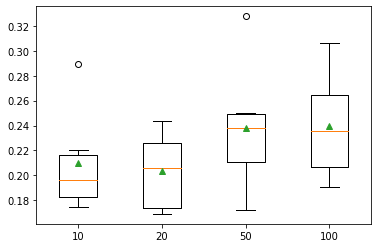

In [32]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [33]:
model_gb = GradientBoostingClassifier()
model_gb.fit(X_low, y_01)

GradientBoostingClassifier()

In [34]:
n_scores_f1 = cross_val_score(model, X_low, y_01, scoring='f1', cv=cv, n_jobs=-1)
print(f'F1-score: {np.mean(n_scores_f1):.3f} ({np.std(n_scores_f1):3f})')

F1-score: 0.347 (0.052560)


In [35]:
# Test GradientBoosting with different number of trees
def get_models():
    models = dict()
    n_trees = [10, 20, 50, 100]
    
    for n in n_trees:
        models[str(n)] = GradientBoostingClassifier(n_estimators=n)
        
    return models

def evaluate(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1)
    
    return scores

In [36]:
models = get_models()

results, names = list(), list()

for name, model in models.items():
    scores = evaluate(model_gb, X_low, y_01)
    results.append(scores)
    names.append(name)
    print(f'{name: >4} {np.mean(scores):.3f} ({np.std(scores):.3f})')

  10 0.089 (0.015)
  20 0.091 (0.017)
  50 0.090 (0.016)
 100 0.092 (0.019)


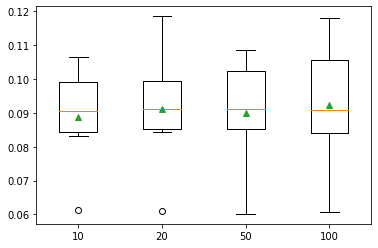

In [37]:
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

In [38]:
model_xgb = XGBClassifier(use_label_encoder=False)
model_xgb.fit(X_low, y_01)

n_scores_f1 = cross_val_score(model_xgb, X_low, y_01, scoring='f1', cv=cv, n_jobs=-1)

[22:12:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [39]:
print(f'F1-score: {np.mean(n_scores_f1):.3f} ({np.std(n_scores_f1):3f})')

F1-score: 0.413 (0.059105)
